In [21]:
import pandas as pd

import numpy as np

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


from gensim.models import Word2Vec

import matplotlib.pyplot as plt

**Ouvrir les CSV et diviser train en train et validation**

In [3]:
df_test = pd.read_csv('../data/test.csv')
df_train = pd.read_csv('../data/train.csv')
df_test 

,doc_id,titre,type,difficulte,cout,ingredients,recette
0,recette_84191.xml,Roulé à la confiture de lait,Dessert,Moyennement difficile,Bon marché,- Pour la garniture: - 1 boîte de lait concent...,"La veille, préparer de la confiture de lait en..."
1,recette_26585.xml,Croissants aux amandes,Dessert,Moyennement difficile,Moyen,- 250 g de farine - 1 pincée de sel - 1 cuillè...,Croissants : Pétrir les ingrédients pour en fa...
2,recette_176139.xml,Quinoa Phileas (aux légumes croquants et sauci...,Plat principal,Moyennement difficile,Moyen,- 250 g de quinoa - 1 gros oignon blanc - 1 g...,Faites cuire le quinoa pendant 12 minutes dans...
3,recette_14285.xml,Magret de canard à la crème de mûre,Plat principal,Moyennement difficile,Moyen,- 1 magret de canard - 5 cl de crème de mûre -...,"Après avoir confectionné la sauce au vin, lui ..."
4,recette_20895.xml,St-Jacques a la sauce aux huitres et aux asperges,Entrée,Moyennement difficile,Moyen,- 10 cl de vin blanc sec - 18 asperges vertes ...,"Ouvrez, videz et nettoyez les coquilles Saint-..."
...,...,...,...,...,...,...,...
1383,recette_20785.xml,Galettes de pommes de terre aux navets,Plat principal,Facile,Moyen,- 750 g de pommes de terre - 750 g de navets -...,Râper les légumes et les assaisonner. Ajouter ...
1384,recette_28768.xml,Terrine d'aubergines au thon de Nadine (4ème r...,Entrée,Facile,Bon marché,"- 4 petits poivrons ou 3 gros, de chaque coule...","Laver les poivrons, les placer entiers dans un..."
1385,recette_73573.xml,Gateau aux amandes et fleur d'oranger,Dessert,Facile,Bon marché,- 250 g de farine - 1/2 sachet de levure - 1...,"Mélanger la farine, la levure, le sucre, la fl..."
1386,recette_166909.xml,Cailles au vin rouge,Plat principal,Facile,Moyen,- 4 - 6 cailles (dépend si ce sont de gros man...,"Tout d'abords, vérifier que vos cailles n'aien..."


In [4]:
df_train, df_validation = train_test_split(df_train, test_size=0.2, random_state=42)
print(df_train.shape, df_validation.shape, df_test.shape)

(9978, 7) (2495, 7) (1388, 7)


In [5]:
df_train.to_csv("../data/train1.csv", index=False)
df_validation.to_csv("../data/validation.csv", index=False)

**Prétraitement**

In [6]:
df_train["text"] = df_train["titre"] + " " + df_train["recette"]
df_test["text"] = df_test["titre"] + " " + df_test["recette"]
df_validation["text"] = df_validation["titre"] + " " + df_validation["recette"]


In [7]:
nltk.download('stopwords')

# Définir les mots-outils en français
stop_words = set(stopwords.words('french'))

def preprocess_text(text):
    # Conversion en minuscules
    text = text.lower()
    # Suppression des mots-outils
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df_validation['text'] = df_validation['text'].apply(preprocess_text)
df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /home/raclax/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vectorisation avec TF-IDF


In [10]:
vectorizer = TfidfVectorizer()
x_train_tf = vectorizer.fit_transform(df_train['text'])
x_test_tf = vectorizer.transform(df_test['text'])
x_validation_tf = vectorizer.transform(df_validation['text'])

y_train = df_train['type']
y_test = df_test['type']
y_validation = df_validation['type']


encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

Vectorisation avec Word2Vec

In [12]:
df_train["tokens"] = df_train["text"].apply(lambda x: x.split())
df_validation["tokens"] = df_validation["text"].apply(lambda x: x.split())
df_test["tokens"] = df_test["text"].apply(lambda x: x.split())

w2v_model = Word2Vec(sentences=df_train["tokens"], vector_size=100, window=5, min_count=2, workers=4)

def document_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

x_train_w2v = np.vstack(df_train["tokens"].apply(lambda x: document_vector(x, w2v_model)))
x_validation_w2v = np.vstack(df_validation["tokens"].apply(lambda x: document_vector(x, w2v_model)))
x_test_w2v = np.vstack(df_test["tokens"].apply(lambda x: document_vector(x, w2v_model)))

df_train.drop(columns=["tokens"], inplace=True)
df_validation.drop(columns=["tokens"], inplace=True)
df_test.drop(columns=["tokens"], inplace=True)

print("Word2Vec vectorization completed!")

Word2Vec vectorization completed!


In [20]:
print("Répartition des étiquettes dans le sous-ensemble d'entraînement (train) :")
print(y_train.value_counts(normalize=True))

print("\nRépartition des étiquettes dans le sous-ensemble de test (test) :")
print(y_test.value_counts(normalize=True))

print("\nRépartition des étiquettes dans le sous-ensemble de validation (validation) :")
print(y_validation.value_counts(normalize=True))

Répartition des étiquettes dans le sous-ensemble d'entraînement (train) :
type
Plat principal    0.465424
Dessert           0.304269
Entrée            0.230307
Name: proportion, dtype: float64

Répartition des étiquettes dans le sous-ensemble de test (test) :
type
Plat principal    0.463977
Dessert           0.293228
Entrée            0.242795
Name: proportion, dtype: float64

Répartition des étiquettes dans le sous-ensemble de validation (validation) :
type
Plat principal    0.464128
Dessert           0.290982
Entrée            0.244890
Name: proportion, dtype: float64


**Baseline (random?)**

                precision    recall  f1-score   support

       Dessert       0.28      0.30      0.29       407
        Entrée       0.22      0.34      0.27       337
Plat principal       0.46      0.31      0.37       644

      accuracy                           0.32      1388
     macro avg       0.32      0.32      0.31      1388
  weighted avg       0.35      0.32      0.32      1388



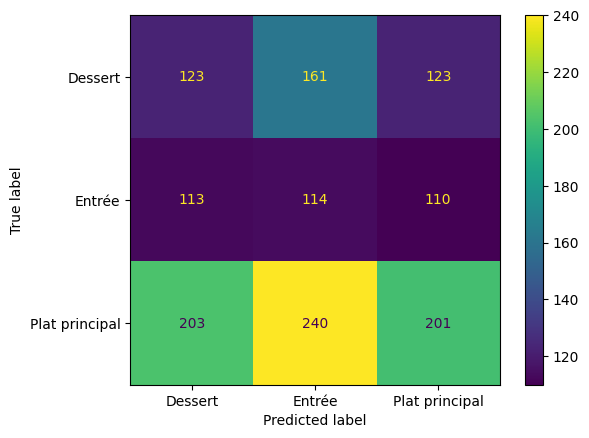

In [16]:
classes = np.unique(y_train) 
random_predictions = np.random.choice(classes, size=len(y_test))

print(classification_report(y_test,random_predictions))
generate_confusion_matrix(random_predictions, y_test)

**Arbre de décision**

                precision    recall  f1-score   support

       Dessert       0.87      0.90      0.89       407
        Entrée       0.51      0.41      0.45       337
Plat principal       0.73      0.78      0.75       644

      accuracy                           0.73      1388
     macro avg       0.70      0.70      0.70      1388
  weighted avg       0.72      0.73      0.72      1388



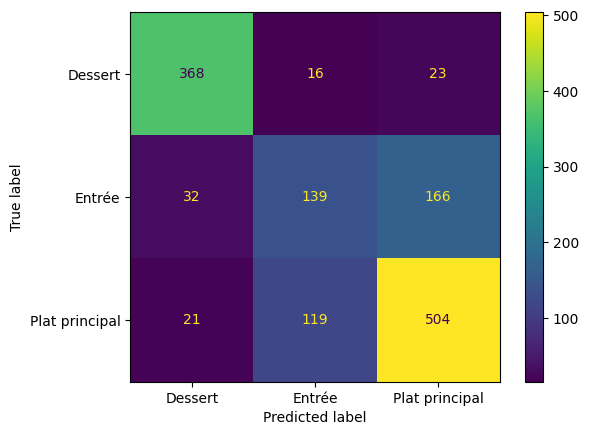

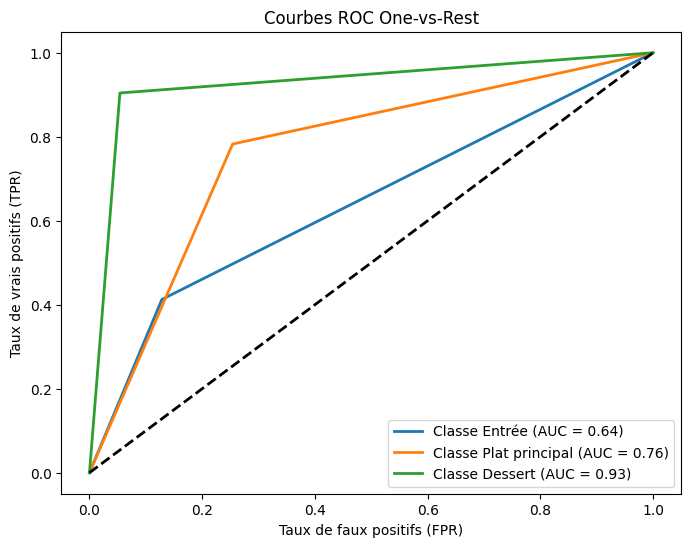


Répartition des scores :
[0.0, 0.1] : 0 documents
[0.1, 0.2] : 0 documents
[0.2, 0.3] : 0 documents
[0.3, 0.4] : 0 documents
[0.4, 0.5] : 27 documents
[0.5, 0.6] : 28 documents
[0.6, 0.7] : 73 documents
[0.7, 0.8] : 128 documents
[0.8, 0.9] : 152 documents
[0.9, 1.0] : 980 documents


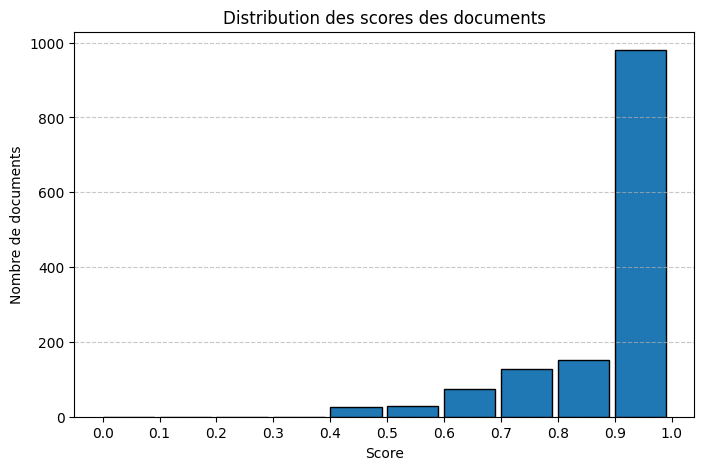

In [17]:
model = DecisionTreeClassifier(max_depth=10, random_state=42)
model.fit(x_train_w2v, y_train) #x_train_tf

predictions = model.predict(x_test_w2v) #x_test_tf
y_pred_proba = model.predict_proba(x_test_w2v) #x_test_tf

print(classification_report(y_test,predictions))
generate_confusion_matrix(predictions, y_test)

plot_roc_curve(y_test,predictions)
plot_score_distribution(y_pred_proba)

**SVM**

                precision    recall  f1-score   support

       Dessert       0.95      0.98      0.96       407
        Entrée       0.71      0.51      0.59       337
Plat principal       0.79      0.89      0.84       644

      accuracy                           0.82      1388
     macro avg       0.82      0.79      0.80      1388
  weighted avg       0.82      0.82      0.81      1388



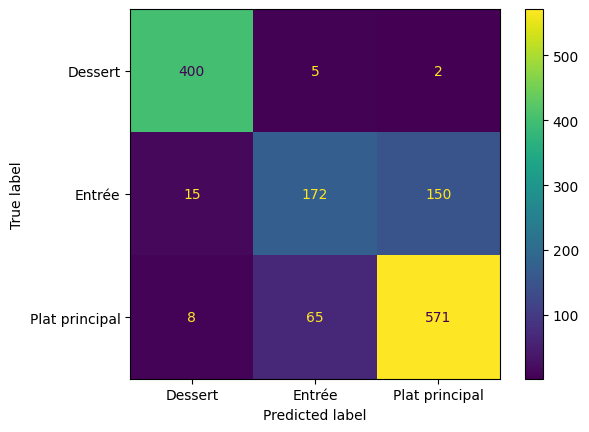

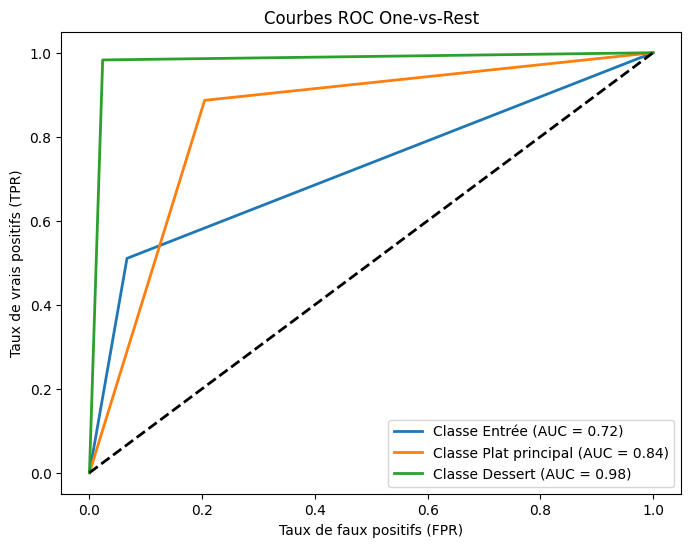


Répartition des scores :
[0.0, 0.1] : 0 documents
[0.1, 0.2] : 0 documents
[0.2, 0.3] : 0 documents
[0.3, 0.4] : 5 documents
[0.4, 0.5] : 27 documents
[0.5, 0.6] : 162 documents
[0.6, 0.7] : 164 documents
[0.7, 0.8] : 195 documents
[0.8, 0.9] : 244 documents
[0.9, 1.0] : 591 documents


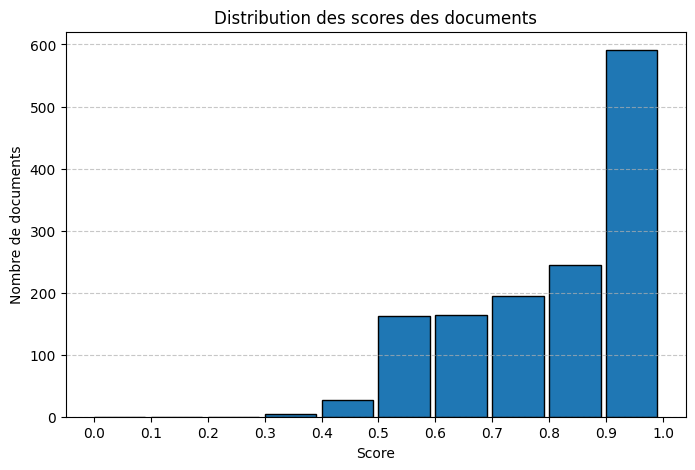

In [18]:
model = SVC(kernel='linear', probability=True)
model.fit(x_train_w2v, y_train_encoded) #x_train_tf

y_pred_encoded = model.predict(x_test_w2v) #x_test_tf
y_pred_proba = model.predict_proba(x_test_w2v) #x_test_tf


y_pred = encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test,y_pred))
generate_confusion_matrix(y_pred, y_test)

plot_roc_curve(y_test,y_pred)
plot_score_distribution(y_pred_proba)

**Random forest**

                precision    recall  f1-score   support

       Dessert       0.91      0.97      0.94       407
        Entrée       0.67      0.46      0.55       337
Plat principal       0.78      0.87      0.82       644

      accuracy                           0.80      1388
     macro avg       0.79      0.77      0.77      1388
  weighted avg       0.79      0.80      0.79      1388



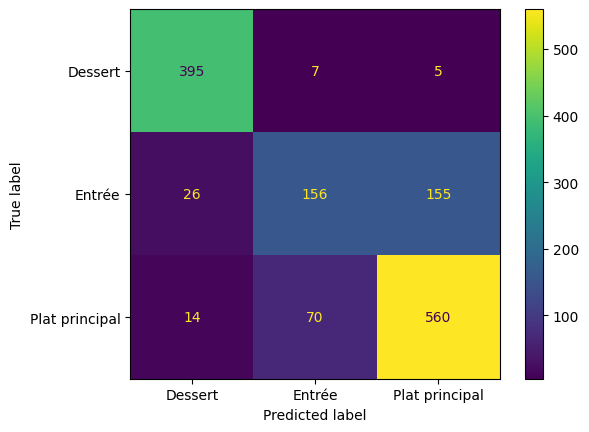

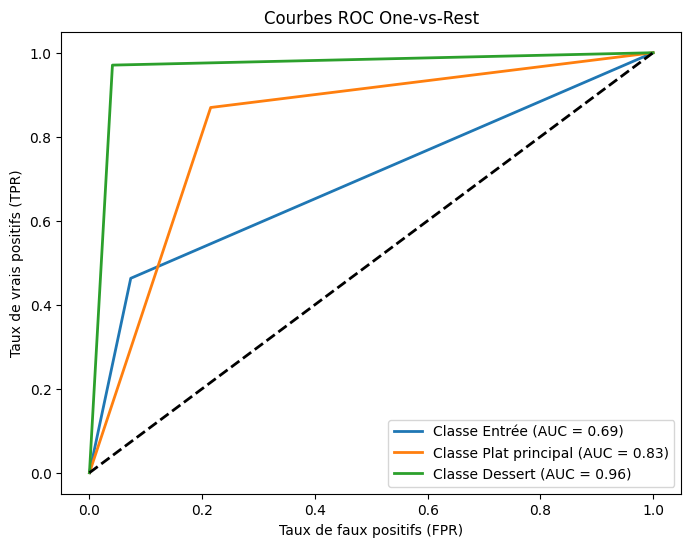


Répartition des scores :
[0.0, 0.1] : 0 documents
[0.1, 0.2] : 0 documents
[0.2, 0.3] : 0 documents
[0.3, 0.4] : 19 documents
[0.4, 0.5] : 120 documents
[0.5, 0.6] : 238 documents
[0.6, 0.7] : 202 documents
[0.7, 0.8] : 189 documents
[0.8, 0.9] : 251 documents
[0.9, 1.0] : 369 documents


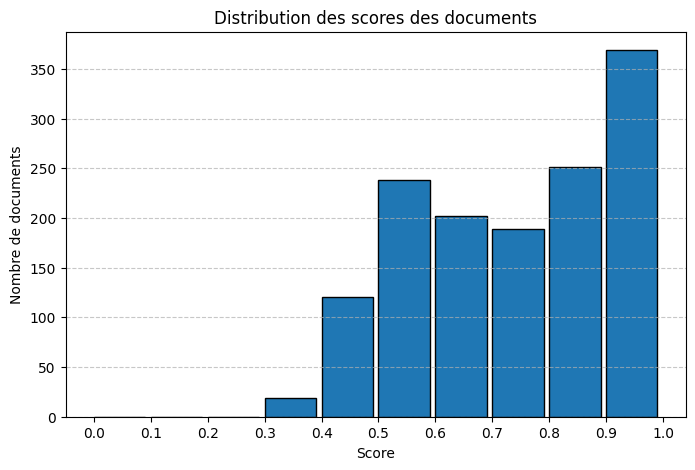

In [19]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(x_train_w2v, y_train_encoded) #x_train_tf

y_pred_encoded = model.predict(x_test_w2v) #x_test_tf
y_pred_proba = model.predict_proba(x_test_w2v) #x_test_tf


y_pred = encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test,y_pred))
generate_confusion_matrix(y_pred, y_test)

plot_roc_curve(y_test,y_pred)
plot_score_distribution(y_pred_proba)


**Naive Bayes**

TF-IDF

                precision    recall  f1-score   support

       Dessert       0.96      0.97      0.96       407
        Entrée       0.95      0.11      0.20       337
Plat principal       0.68      0.99      0.81       644

      accuracy                           0.77      1388
     macro avg       0.86      0.69      0.66      1388
  weighted avg       0.83      0.77      0.71      1388



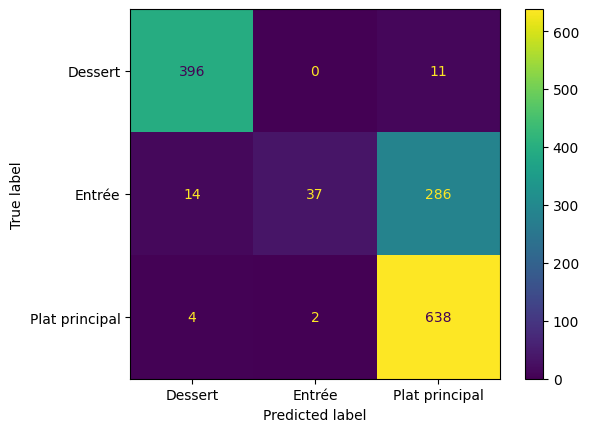

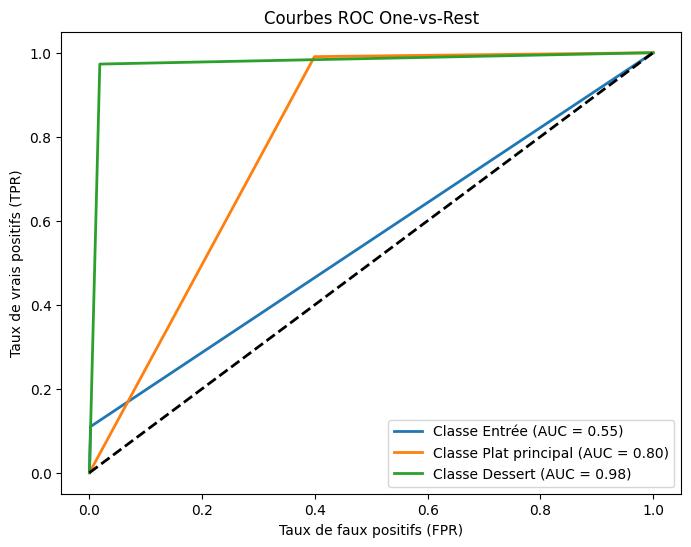


Répartition des scores :
[0.0, 0.1] : 0 documents
[0.1, 0.2] : 0 documents
[0.2, 0.3] : 0 documents
[0.3, 0.4] : 5 documents
[0.4, 0.5] : 32 documents
[0.5, 0.6] : 79 documents
[0.6, 0.7] : 84 documents
[0.7, 0.8] : 151 documents
[0.8, 0.9] : 262 documents
[0.9, 1.0] : 775 documents


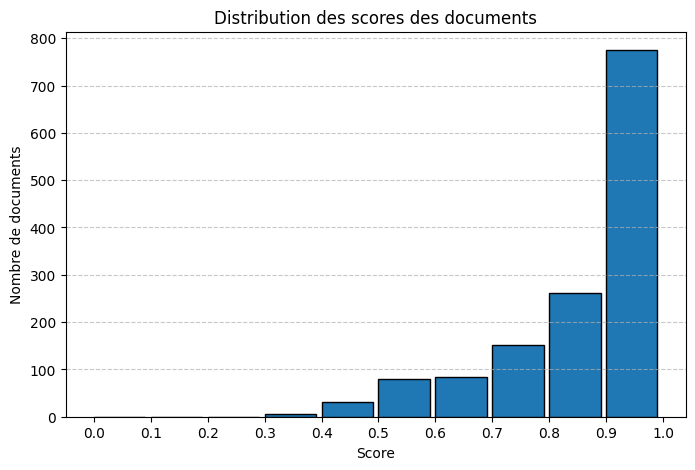

In [22]:
model = MultinomialNB()
model.fit(x_train_tf, y_train_encoded)

y_pred_encoded = model.predict(x_test_tf)
y_pred_proba = model.predict_proba(x_test_tf)

y_pred = encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test,y_pred))
generate_confusion_matrix(y_pred, y_test)

plot_roc_curve(y_test,y_pred)
plot_score_distribution(y_pred_proba)

Word2Vec

                precision    recall  f1-score   support

       Dessert       0.86      0.89      0.87       407
        Entrée       0.67      0.04      0.07       337
Plat principal       0.66      0.97      0.78       644

      accuracy                           0.72      1388
     macro avg       0.73      0.63      0.57      1388
  weighted avg       0.72      0.72      0.64      1388



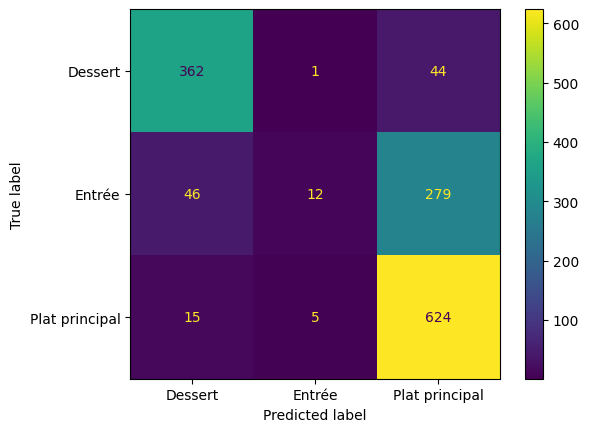

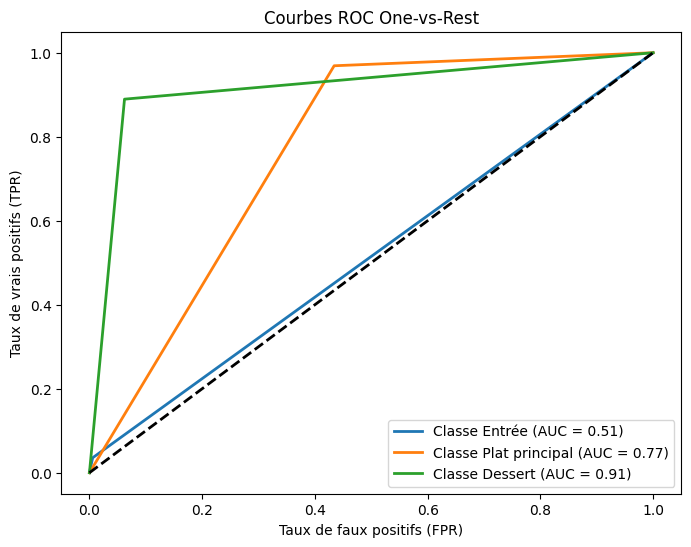


Répartition des scores :
[0.0, 0.1] : 0 documents
[0.1, 0.2] : 0 documents
[0.2, 0.3] : 0 documents
[0.3, 0.4] : 72 documents
[0.4, 0.5] : 278 documents
[0.5, 0.6] : 367 documents
[0.6, 0.7] : 381 documents
[0.7, 0.8] : 238 documents
[0.8, 0.9] : 51 documents
[0.9, 1.0] : 1 documents


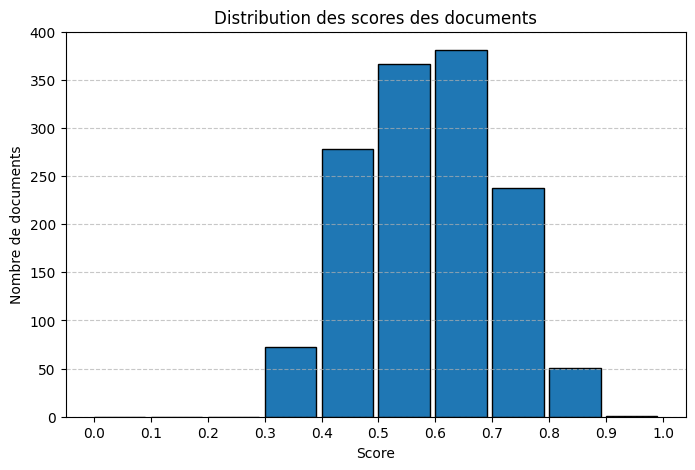

In [20]:
scaler = MinMaxScaler()
X_train_w2v_scaled = scaler.fit_transform(x_train_w2v)
X_validation_w2v_scaled = scaler.transform(x_validation_w2v)
X_test_w2v_scaled = scaler.transform(x_test_w2v)

model = MultinomialNB()
model.fit(X_train_w2v_scaled, y_train_encoded)

y_pred_encoded = model.predict(X_test_w2v_scaled)
y_pred_proba = model.predict_proba(X_test_w2v_scaled)

y_pred = encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test,y_pred))
generate_confusion_matrix(y_pred, y_test)

plot_roc_curve(y_test,y_pred)
plot_score_distribution(y_pred_proba)


**Générer une matrice de confusion**

In [13]:
def generate_confusion_matrix(prediction, classes):
    labels = sorted(list(set(classes)))
    cm = confusion_matrix(classes, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

**Afficher la courbe ROC**

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(y_test, y_pred):

    class_labels = ["Entrée", "Plat principal", "Dessert"]
    # Vérifier que y_test et y_pred sont bien 1D
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    # Binariser les labels en One-vs-Rest
    y_test_bin = label_binarize(y_test, classes=class_labels)
    y_pred_bin = label_binarize(y_pred, classes=class_labels)

    plt.figure(figsize=(8, 6))

    for i, class_name in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.title("Courbes ROC One-vs-Rest")
    plt.legend(loc="lower right")
    plt.show()



**Afficher la distribution en fonction des scores**

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_score_distribution(y_pred):

    max_scores = np.max(y_pred, axis=1)
    
    bins = np.arange(0, 1.1, 0.1)
    hist, bin_edges = np.histogram(max_scores, bins=bins)
    
    print("\nRépartition des scores :")
    for i in range(len(bins) - 1):
        print(f"[{bins[i]:.1f}, {bins[i+1]:.1f}] : {hist[i]} documents")

    plt.figure(figsize=(8, 5))
    plt.bar(bins[:-1], hist, width=0.09, edgecolor="black", align="edge")
    plt.xlabel("Score")
    plt.ylabel("Nombre de documents")
    plt.title("Distribution des scores des documents")
    plt.xticks(bins)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
